# Random Forest

## Self developed Random Forest Classifier Class

In [1]:
import numpy as np
import math

def std_agg(cnt, s1, s2): 
    """
    Calculate the standard deviation of a sample.

    Parameters:
    cnt (int): The number of elements in the sample.
    s1 (float): The sum of the elements in the sample.
    s2 (float): The sum of squares of the elements in the sample.

    Returns:
    float: The standard deviation of the sample.
    """
    return math.sqrt((s2/cnt) - (s1/cnt)**2)


class DecisionTree:
    """
    A class that implements a Decision Tree.

    Attributes:
    x (np.array): Feature data for the tree.
    y (np.array): Target data for the tree.
    n_features (int): The number of features to consider when finding the best split.
    f_idxs (np.array): Array of feature indices.
    depth (int): The maximum depth of the tree.
    min_leaf (int): The minimum number of samples required to split an internal node.
    """
    def __init__(self, x, y, n_features=None, f_idxs=None, depth=10, min_leaf=2):
        """
        The constructor for DecisionTree class.

        Parameters:
        x (np.array): Feature data for the tree.
        y (np.array): Target data for the tree.
        n_features (int, optional): The number of features to consider when finding the best split.
        f_idxs (np.array, optional): Array of feature indices.
        depth (int, optional): The maximum depth of the tree.
        min_leaf (int, optional): The minimum number of samples required to split an internal node.
        """
        if f_idxs is None:
            f_idxs = np.arange(x.shape[1])
        if n_features is None:
            n_features = int(np.sqrt(x.shape[1]))

        self.x, self.y, self.f_idxs, self.min_leaf = x, y, f_idxs, min_leaf
        self.n_features = n_features
        self.n, self.c = x.shape[0], x.shape[1]
        self.val = np.mean(y)
        self.score = float('inf')
        self.depth = depth
        self.split()

    def split(self):
        """
        Method to split the data into two based on the condition that gives the best information gain.
        """
        for i in np.random.choice(self.f_idxs, self.n_features, replace=False):
            self.find_better_split(i)
        if self.score == float('inf') or self.depth <= 0: 
            return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        lf_idxs = np.random.permutation(self.f_idxs)
        rf_idxs = np.random.permutation(self.f_idxs)
        self.lhs = DecisionTree(self.x[lhs], self.y[lhs], self.n_features, lf_idxs, self.depth-1, self.min_leaf)
        self.rhs = DecisionTree(self.x[rhs], self.y[rhs], self.n_features, rf_idxs, self.depth-1, self.min_leaf)

    def find_better_split(self, var_idx):
        """
        Method to find the best split for the data.
        
        Parameters:
        var_idx (int): The index of the variable to consider for splitting.
        """
        x, y = self.x[:, var_idx], self.y
        sort_idx = np.argsort(x)
        sort_y, sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt, rhs_sum, rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt, lhs_sum, lhs_sum2 = 0, 0.0, 0.0

        for i in range(0, self.n-self.min_leaf):
            xi, yi = sort_x[i], sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i<self.min_leaf-1 or xi==sort_x[i+1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score: 
                self.var_idx, self.score, self.split = var_idx, curr_score, xi

    @property
    def split_col(self): 
        """
        Property method to get the column of data on which the split condition is applied.
        
        Returns:
        np.array: The column of data on which the split condition is applied.
        """
        return self.x[:, self.var_idx]

    def predict(self, x):
        """
        Method to predict the target value for given features.

        Parameters:
        x (np.array): The features for which to predict the target values.

        Returns:
        np.array: The predicted target values.
        """
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        """
        Method to predict the target value for a single sample.

        Parameters:
        xi (np.array): The features of the sample.

        Returns:
        float: The predicted target value.
        """
        if self.score == float('inf') or self.depth <= 0: 
            return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)


class RandomForest:
    """
    A class that implements a Random Forest.

    Attributes:
    x (np.array): Feature data for the forest.
    y (np.array): Target data for the forest.
    n_trees (int): The number of trees in the forest.
    sample_sz (int): The number of samples to use for building each tree.
    n_features (int): The number of features to consider when finding the best split.
    """
    def __init__(self, x, y, n_trees, sample_sz, n_features, depth=10, min_leaf=5):
        """
        The constructor for RandomForest class.

        Parameters:
        x (np.array): Feature data for the forest.
        y (np.array): Target data for the forest.
        n_trees (int): The number of trees in the forest.
        sample_sz (int): The number of samples to use for building each tree.
        n_features (int): The number of features to consider when finding the best split.
        depth (int, optional): The maximum depth of the trees.
        min_leaf (int, optional): The minimum number of samples required to split an internal node.
        """
        np.random.seed(12)
        if n_features is None:
            n_features = x.shape[1]
        self.x, self.y, self.sample_sz, self.n_features = x, y, sample_sz, n_features
        self.depth, self.min_leaf = depth, min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]


    def create_tree(self):
        """
        Method to create a tree using a random subset of the data.

        Returns:
        DecisionTree: The created tree.
        """
        idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        f_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        return DecisionTree(self.x[idxs], self.y[idxs], self.n_features, f_idxs,
                            depth=self.depth, min_leaf=self.min_leaf)

        
    def predict(self, x):
        """
        Method to predict the target value for given features.

        Parameters:
        x (np.array): The features for which to predict the target values.

        Returns:
        np.array: The predicted target values.
        """
        return np.mean([t.predict(x) for t in self.trees], axis=0)

## Data Preperation

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load CSV file into a DataFrame
df = pd.read_csv("C:/Users/X1L3F/Documents/Dev/VDKI/RF/All_Labels_completed.csv")

# Define target column and feature columns
target_column = 'label'
feature_columns = ['con_num', 'con_area', 'orb_num_front', 'orb_num_back', 'cs_green', 'cs_yellow', 
                   'cs_white', 'cs_purple', 'cs_red', 'cs_blue', 'cs_brown']

# Split data into features (X) and target (y)
X_all = df[feature_columns]
y_all = df[target_column]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=1)

# Convert pandas DataFrames and Series to numpy arrays
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

## Our Model Test

In [3]:
forest = RandomForest(X_train, y_train, n_trees=10, sample_sz=X_train.shape[0], n_features=X_train.shape[1], depth=20, min_leaf=5)

predictions = forest.predict(X_test)
class_predictions = np.round(predictions).astype(int)
accuracy = np.sum(class_predictions == y_test) / len(y_test)

print(f"Test accuracy: {accuracy*100:.2f}%")


Test accuracy: 54.30%


## Sklearn Model Test

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

sk_forest = RandomForestClassifier(n_estimators=10, max_depth=10, min_samples_leaf=5, random_state=42)
sk_forest.fit(X_train, y_train)
sk_predictions = sk_forest.predict(X_test)
sk_accuracy = accuracy_score(y_test, sk_predictions)

print(f"Test accuracy (scikit-learn): {sk_accuracy*100:.2f}%")

Test accuracy (scikit-learn): 65.27%


## Confusion Matrix

In [5]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import os

def key_metrics_generation(y_true, y_pred, title_cm, saving_file_path_cm):
    # Compute metrics
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Print metrics
    print("Precision: {:.2f}%".format(precision*100))
    print("Recall: {:.2f}%".format(recall*100))
    print("F1-Score: {:.2f}%".format(f1*100))

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Plot confusion matrix
    plt.imshow(cm_percentage, interpolation='nearest', cmap=plt.cm.rainbow)
    plt.colorbar(label='%')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(title_cm)
    plt.savefig(os.path.join(saving_file_path_cm, title_cm + '.png'))
    plt.show()

Precision: 57.27%
Recall: 54.30%
F1-Score: 54.42%


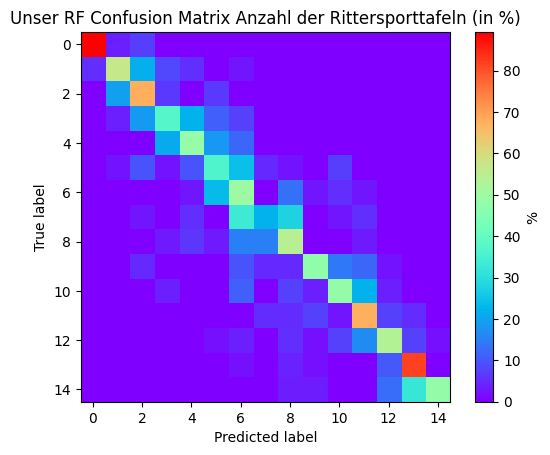

Precision: 66.18%
Recall: 65.27%
F1-Score: 65.22%


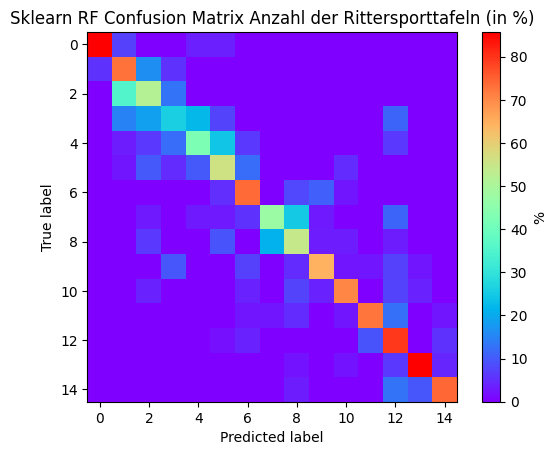

In [6]:
key_metrics_generation(y_test, class_predictions, 'Unser RF Confusion Matrix Anzahl der Rittersporttafeln (in %)', "C:/Users/X1L3F/Documents/Dev/VDKI/RF/")
key_metrics_generation(y_test, sk_predictions, 'Sklearn RF Confusion Matrix Anzahl der Rittersporttafeln (in %)', "C:/Users/X1L3F/Documents/Dev/VDKI/RF/")